In [1]:
import os

In [2]:
os.makedirs('artifacts', exist_ok=True)

In [3]:
os.makedirs('artifacts\data', exist_ok=True)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,SimpleRNN
from sklearn.model_selection import train_test_split


In [5]:
df = pd.read_csv('artifacts/data/fake_and_real_news.csv')

In [6]:
df

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real
...,...,...
9895,Wikileaks Admits To Screwing Up IMMENSELY Wit...,Fake
9896,Trump consults Republican senators on Fed chie...,Real
9897,Trump lawyers say judge lacks jurisdiction for...,Real
9898,WATCH: Right-Wing Pastor Falsely Credits Trum...,Fake


In [48]:
df[df['label']== 1]['Text'][2]

'Trump proposes U.S. tax overhaul, stirs concerns on deficit WASHINGTON (Reuters) - President Donald Trump proposed on Wednesday the biggest U.S. tax overhaul in three decades, calling for tax cuts for most Americans, but prompting criticism that the plan favors business and the rich and could add trillions of dollars to the deficit. The proposal drew a swift, skeptical response from Senator Bob Corker, a leading Republican “fiscal hawk,” who vowed not to vote for any federal tax package financed with borrowed money. “What I can tell you is that I’m not about to vote for any bill that increases our deficit, period,” Corker, who said on Tuesday he would not seek re-election in 2018, told reporters. Trump said his tax plan was aimed at helping working people, creating jobs and making the tax code simpler and fairer. But it faces an uphill battle in the U.S. Congress with Trump’s own Republican Party divided over it and Democrats hostile. The plan would lower corporate and small-business 

In [45]:
df[df['label']== 0 ]['Text'][0]

' Top Trump Surrogate BRUTALLY Stabs Him In The Back: ‘He’s Pathetic’ (VIDEO) It s looking as though Republican presidential candidate Donald Trump is losing support even from within his own ranks. You know things are getting bad when even your top surrogates start turning against you, which is exactly what just happened on Fox News when Newt Gingrich called Trump  pathetic. Gingrich knows that Trump needs to keep his focus on Hillary Clinton if he even remotely wants to have a chance at defeating her. However, Trump has hurt feelings because many Republicans don t support his sexual assault against women have turned against him, including House Speaker Paul Ryan (R-WI). So, that has made Trump lash out as his own party.Gingrich said on Fox News: Look, first of all, let me just say about Trump, who I admire and I ve tried to help as much as I can. There s a big Trump and a little Trump. The little Trump is frankly pathetic. I mean, he s mad over not getting a phone call? Trump s referr

In [7]:
df.shape

(9900, 2)

In [8]:
df.isna().sum()

Text     0
label    0
dtype: int64

In [41]:
df['label'].value_counts()

label
0    5000
1    4900
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

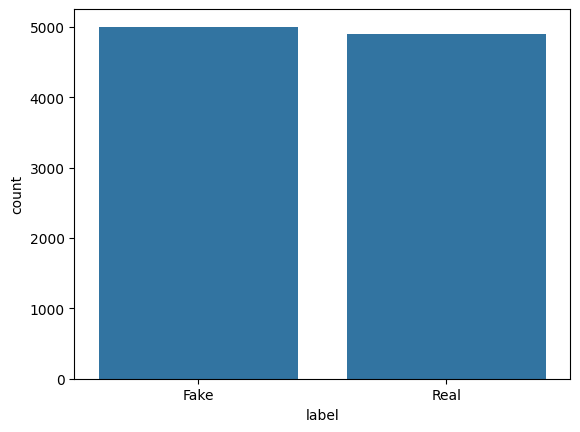

In [9]:
sns.countplot(x = df['label'])

In [10]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'Fake' else 1)

In [11]:
df['label']

0       0
1       1
2       1
3       0
4       1
       ..
9895    0
9896    1
9897    1
9898    0
9899    0
Name: label, Length: 9900, dtype: int64

In [12]:
def preprocess_data(df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['Text'])
    sequences = tokenizer.texts_to_sequences(df['Text']) 
    padded_sequences = pad_sequences(sequences, maxlen=500)
    return padded_sequences, df['label'].values, tokenizer


In [13]:
x,y,tokenizer = preprocess_data(df)

In [14]:
vocab_size = len(tokenizer.word_index)+1

In [15]:
tokenizer

In [16]:
x.shape

(9900, 500)

In [17]:
y.shape[0]

9900

In [18]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

In [19]:
x_train.shape,x_test.shape

((6633, 500), (3267, 500))

In [20]:
y_train.shape,y_test.shape

((6633,), (3267,))

In [21]:
y_test

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [22]:
from tensorflow.keras.losses import BinaryCrossentropy
loss = BinaryCrossentropy()

In [23]:

model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=32,input_length=500))
model.add(SimpleRNN(100,activation='relu',return_sequences=True))
model.add(SimpleRNN(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           2203744   
                                                                 
 simple_rnn (SimpleRNN)      (None, 500, 100)          13300     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2221333 (8.47 MB)
Trainable params: 2221333 (8.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
earlystopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)
earlystopping

In [27]:
history = model.fit(
    x_train, y_train,
    epochs = 10,
    batch_size = 32,
    validation_data=(x_test, y_test),
    callbacks=[earlystopping]
)

Epoch 1/10
208/208 [==============================] - 33s 154ms/step - loss: 0.1178 - accuracy: 0.9623 - val_loss: 0.0200 - val_accuracy: 0.9945
Epoch 2/10
208/208 [==============================] - 32s 153ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0154 - val_accuracy: 0.9963
Epoch 3/10
208/208 [==============================] - 32s 152ms/step - loss: 7.9743e-04 - accuracy: 1.0000 - val_loss: 21521.1230 - val_accuracy: 0.9972
Epoch 4/10
208/208 [==============================] - 31s 151ms/step - loss: 5.4406 - accuracy: 0.9849 - val_loss: 0.5481 - val_accuracy: 0.8815
Epoch 5/10
208/208 [==============================] - 33s 156ms/step - loss: 36943.7305 - accuracy: 0.9160 - val_loss: 5.9755 - val_accuracy: 0.5112
Epoch 6/10
208/208 [==============================] - 33s 157ms/step - loss: 0.3424 - accuracy: 0.9409 - val_loss: 0.0445 - val_accuracy: 0.9896


In [28]:
# Save Model

model.save('SimpleRNN.h5')

d:\RNN-LSTM_RNN-GRU\even\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
pred = model.predict(x_test)

103/103 [==============================] - 4s 32ms/step


In [30]:
prediction_proba = pred[0][0]

In [31]:
if prediction_proba > 0.5:
    print('Fake_News')
else:
    print('Real_News')

Real_News


In [32]:
pred[0][0]

8.618206e-08

In [37]:
pred

array([[8.618206e-08],
       [9.976351e-01],
       [9.970339e-01],
       ...,
       [9.995723e-01],
       [9.990155e-01],
       [1.552889e-07]], dtype=float32)